# NLP21@BGU.CS - HW1

## Michael Elhadad michael.elhadad@example.com
### NLP 2021 - HW1 (http://www.cs.bgu.ac.il/~elhadad/nlp21/hw1.html)

Nov 2020

In [1]:
# Boring preliminaries
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division
import nltk
import pandas as pd
import builtins
from nltk.util import ngrams 
import numpy as np
import matplotlib.pyplot as plt
import math
import string

nltk.download('punkt')


Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# helper class to print nice outputs
class txt:
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def make_bold(text):
    return txt.BOLD+ text + txt.END

def make_underline(text):
    return txt.UNDERLINE+ text + txt.END

<h2>Content</h2>

* <a href="#P1">Part 1: Language Models</a>
  * <a href="#data">1.1 Data Exploration</a>
    * <a href="#explore">1.1.1 Gathering basic statistics</a>
    * <a href="#power">1.1.2 Zipf and Power Law</a>
  * <a href="#ngram">1.2 n-gram model</a>
    * <a href="#n_parameters">1.2.1 How much memory do you expect a model to occupy?</a>
    * <a href="#train_lm">1.2.2 N-gram Word LM</a>
  * <a href="#eval">1.3 Language Model Evaluation</a>
    * <a href="#per">1.3.1 Perplexity</a>
    * <a href="#smoothing">1.3.2 Smoothing</a>
    * <a href="#overfit">1.3.3 Perplexity according to the order of the n-gram model
    * <a href="#test-lm">1.3.4 Test the best n-gram LM</a>
    * <a href="#gen">1.3.5 Generating Text using Language Models</a>
  * <a href="#nn-lm">1.4 Character language model</a>
    * <a href="#effectiveness">1.4.1 Read and Summarize</a>
    * <a href="#recipes">1.4.2 Recipes with a Character LM</a>
* <a href="#P2">Part 2: Polynomial curve fitting</a>
  * <a href="#syntheticdata">2.1 Synthetic data generation</a>
  * <a href="#curvefitting">2.2 Polynomial Curve Fitting</a>
  * <a href="#regularization">2.3 Polynomial Curve Fitting with Regularization</a>
  * <a href="#prob-regr">2.4 Probabilistic Regression Model</a>
* <a href="#P3">Part 3: Text Classification with Character RNN</a>
  * <a href="#readtut">3.1 Summarize the PyTorch Tutorial</a>
  * <a href="#newdata">3.2 Explore the Cities Dataset</a>
  * <a href="#citiesmodel">3.3 Train and Evaluate the RNN Model for Cities</a>
  * <a href="#bettercitiesmodel">3.4 (Optional) Improve the Model</a>

<hr>
<a name="P1"></a>
<h2>Part 1: Language Models</h2>

<a name="data"></a>
<h3>1.1 Data Exploration</h3>

<a name="explore"></a>
<h4>1.1.1 Gathering Basic Statistics</h4>

In this section, we collect and plot the following information on a text dataset:
<ul>
<li>The total number of tokens</li>
<li>The total number of characters</li>
<li>The total number of distinct words (vocabulary)</li>
<li>The total number of tokens corresponding to the top-N most frequent words in the vocabulary</li>
<li>The token/type ratio in the dataset</li>
<li>The number of types that appear in the dev data but not the training data</li>
<li>The average number and standard deviation of characters per token</li>
<li>The total number of distinct n-grams (of words) that appear in the dataset for n=2,3,4.</li>
<li>The total number of distint n-grams of characters that appear for n=2,3,4,5,6,7.</li>
</ul>

We operate on the PTB dataset, which contains 929k training words, 73k validation words, and 82k test words. 
It is formatted in such a way that only the top 10k most frequent words are in its vocabulary.

We gather the files from <a href="http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz">the dataset</a>
where sentences are segmented one per line and words separated by spaces.  We assume the files are located in "../data/".

###### The data set
First, we created a dictionary of all datasets we got

In [3]:
data = {
    "char_train": '../data/ptb.char.train.txt',
    "char_valid": '../data/ptb.char.valid.txt',
    "char_test": '../data/ptb.char.test.txt',
    "ptb_train": '../data/ptb.train.txt',
    "ptb_valid":'../data/ptb.valid.txt',
    "ptb_test": '../data/ptb.test.txt',
    "shakespeare":'../data/shakespeare_input.txt'
}

You may need to tokenize strings read from the dataset files into lists of tokens.  
Think which method is best appropriate for this dataset given the way it is formatting.
Recall the method based on regular expressions used in Norvig's piece.
Compare it with the the tokenizer provided in the nltk library.

##### Gathering Basic Statistics

We wrote a function that compute number of tocken in a text. 
This function is according to the dataset formatting of ptb_train .

In [4]:
def fix_token(token):
    if token.isalpha() or token.find('-')!=-1 or token.find("'")!=-1 :
        return token
    return None

# if we need to clean code
def get_tokens_old(text):
    tokens = nltk.word_tokenize(text)
    # remove  all tokens that are not alphabetic i.e '<' , '$' , ect .
    tokens = [token for token in tokens if fix_token(token)!=None]
    return tokens

def get_tokens(text):
    return nltk.word_tokenize(text)
 
# for debbuging - we define function that prints the first num_of_tokens tokens
def print_tokens(text,num_of_tokens):
    tokens=get_tokens(text)
    print(tokens[0:num_of_tokens])

# To compute distinct word we used the set method which store multiple instance of words as one variable
def get_vocabulary(text):
    tokens=get_tokens(text)
    return set(tokens)

# return top-N most frequent words in the vocabulary
# We used nltk built-in methods
def N_most_frequent(text,N):
    tokens=get_tokens(text)
    fdist = nltk.FreqDist(tokens)
    return fdist.most_common(N)

# returs the all distinct n-grams of words
def get_ngrams_words(text,num):
    tokens=get_tokens(text)
#   text.split() we seperate the ngrams into words instead of chars
    return Counter(ngrams(tokens, num))

# returs all number of distinct n-grams of chars
def get_ngrams_chars(text,num):
    return Counter(ngrams(text.replace(' ',''), num))

Let's check our function on a simple text

In [5]:
text= "remove puncturation like . , but we-want-to-keep-this "
print(make_bold("tokens: "),get_tokens(text))

text="check vocab vocab vocab"
vocab=get_vocabulary(text)
print(make_bold("vocab: "),get_vocabulary(text))
assert len(vocab)==2

text = "hi ! this func checks the most common word in this text. \
this is the most interesting test"
print(make_bold("n most"),N_most_frequent(text,3))

print(make_bold("n-gram words: "),get_ngrams_words(text,3))
print(make_bold("n-gram words: "),get_ngrams_chars(text,2))

tokens:  ['remove', 'puncturation', 'like', '.', ',', 'but', 'we-want-to-keep-this']
vocab:  {'check', 'vocab'}
n most [('this', 3), ('the', 2), ('most', 2)]
n-gram words:  Counter({('hi', '!', 'this'): 1, ('!', 'this', 'func'): 1, ('this', 'func', 'checks'): 1, ('func', 'checks', 'the'): 1, ('checks', 'the', 'most'): 1, ('the', 'most', 'common'): 1, ('most', 'common', 'word'): 1, ('common', 'word', 'in'): 1, ('word', 'in', 'this'): 1, ('in', 'this', 'text'): 1, ('this', 'text', '.'): 1, ('text', '.', 'this'): 1, ('.', 'this', 'is'): 1, ('this', 'is', 'the'): 1, ('is', 'the', 'most'): 1, ('the', 'most', 'interesting'): 1, ('most', 'interesting', 'test'): 1})
n-gram words:  Counter({('s', 't'): 7, ('t', 'h'): 5, ('h', 'i'): 4, ('i', 's'): 4, ('h', 'e'): 3, ('m', 'o'): 3, ('i', 'n'): 3, ('t', 'e'): 3, ('e', 'm'): 2, ('o', 's'): 2, ('n', 't'): 2, ('t', 'i'): 2, ('e', 's'): 2, ('i', '!'): 1, ('!', 't'): 1, ('s', 'f'): 1, ('f', 'u'): 1, ('u', 'n'): 1, ('n', 'c'): 1, ('c', 'c'): 1, ('c', 'h'

Next, we define helper methods to compute the total number of distinct words (the vocabulary) and the total number of tokens corresponding to the top-N most frequent words in the vocabulary

let's check our function  on different values of N

In [6]:
# helper function to get all texe of file fname
def get_text(fname):
    file=open(fname,'rt')
    text=file.read()
    file.close()
    return text

In [7]:
text_train=get_text(data['ptb_train'])
text_dev=get_text(data['ptb_valid'])
tokens_train=get_tokens(text_train)
# total num of token, num of chars and num of distinct words
num_of_tokens=len(tokens_train)
num_of_chars= len(text_train)
vocab_size= len(get_vocabulary(text_train))
# 5 most frequent words (we chose 5 for the example)
ten_most_frequent=builtins.sum(freq[1] for freq in N_most_frequent(text,5))
# The token/type ratio in the dataset
token_per_type_ratio= num_of_tokens/vocab_size
# The number of types that appear in the dev data but not the training data
types_in_dev_not_train=len(np.setdiff1d(get_vocabulary(text_dev),get_vocabulary(text_train))[0])
# # The average number and standard deviation of characters per token
chars_per_token = [len(w) for w in tokens_train]
mean_char_per_tok= np.mean(chars_per_token)
std_char_per_tok=np.std(chars_per_token)
# The total number of distinct n-grams (of words) that appear in the dataset for n=2,3,4.

# prints all the data whe gathered until now
print(make_bold('The total number of tokens: ') + str(num_of_tokens) \
      ,make_bold ('Total number of characters: ')+ str(num_of_chars) \
      ,make_bold('Total number of distinct words: ')+ str(vocab_size) \
      ,make_bold('Total number of tokens corresponding to the top-5 most frequent words: ') +str(ten_most_frequent)\
      ,make_bold('token/type ratio: '),str(token_per_type_ratio)\
      ,make_bold('Number of types that appear in the dev data but not the training data: ') + str(types_in_dev_not_train)\
      ,make_bold('total number of tokens corresponding to the top-10 most frequent words: ')+str(ten_most_frequent)\
      ,make_bold('token/type ratio in the dataset: ')+str(token_per_type_ratio)\
      ,make_bold('average number of characters per token: ')+str(mean_char_per_tok)\
      ,make_bold('standard deviation of characters per token: ')+str(std_char_per_tok)\
      ,sep='\n')

print(make_bold('\n number of distinct n-grams of words:'))
# The total number of distinct n-grams (of words) that appear in the dataset for n=2,3,4.
for n in [2,3,4]:
        print(make_underline('\tn='+ str(n)+':'),len(get_ngrams_words(text,n)))

print(make_bold('\n number of distinct n-grams of characters:'))
for n in [2,3,4,5,6,7]:
        print(make_underline('\tn='+ str(n)+':'),len(get_ngrams_chars(text,n)))


The total number of tokens: 978754
Total number of characters: 5101618
Total number of distinct words: 9996
Total number of tokens corresponding to the top-5 most frequent words: 9
token/type ratio: 
97.91456582633053
Number of types that appear in the dev data but not the training data: 6020
total number of tokens corresponding to the top-10 most frequent words: 9
token/type ratio in the dataset: 97.91456582633053
average number of characters per token: 4.2196108521651
standard deviation of characters per token: 2.705689094054091

 number of distinct n-grams of words:
	n=2: 17
	n=3: 17
	n=4: 16

 number of distinct n-grams of characters:
	n=2: 43
	n=3: 56
	n=4: 62
	n=5: 65
	n=6: 65
	n=7: 65


Note how abbreviations in English are tokenized in PTB ("I'm" becomes ["I", "'m"]) and numbers are all replaced by the "N" special token.

<a name="power"></a>
<h4>1.1.2 Zipf and Power Law</h4>

Word count distributions are said to follow <a href="https://en.wikipedia.org/wiki/Power_law">power law distributions</a>. 
In practice, this means that a plot of the log-frequency against the log-rank is nearly linear. 
We will verify that this holds for the Penn Treebank dataset by constructing the appropriate corpus_counts counter:


In [8]:
text=get_text(data['ptb_train'])
tokens = get_tokens(text)
corpus_counts = Counter(tokens)

3.3.2


Text(0, 0.5, 'frequency')

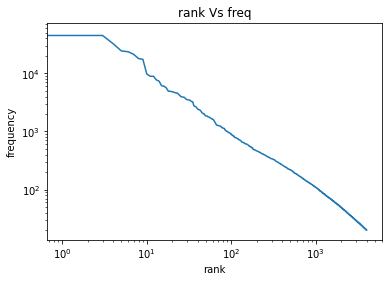

In [12]:
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)

plt.loglog([val for word,val in corpus_counts.most_common(4000)])
plt.title('rank Vs freq')
plt.xlabel('rank')
plt.ylabel('frequency')


As predicted - we got nearly linear graph .
The results make sense because the rank and frequency are proportional to each other .

<a name="ngram"></a>
<h3><a name="ngram">1.2 n-gram Word Language Model</a></h3>

<a name="n_parameters"></a>
<h4>1.2.1 How much memory do you expect a model to occupy?</h4>


###### Solution:
First of all if we notice  the statistics result above we  can tell that as  n growth so the number of n-grams (either characters or words). hence we expect our model to grow according to n .

but let's get mor precise answer:
For our model we need to keep a dictionary of dictionaries  when the keys for the main dictionary is the unique n-grams and the vlue for each key is a dictionary itsels that maps to the distribution of each word appearing after the n-gram. 
If we mark our corups size as N we will get O(N) dictionarirs for evey n-gram and O(N) n-grams so in total we get O(N^2)  memory for our model . 

In The worst-case - there is no duplicated ngrams (or almost all the n-gram are unique), hence the number of n-grams will be equals to the size of the corups it self , N .
In the expected case, the number of distinct n-grams is bounded by $|V|^{n}$ where $|V|$ is the size of the vocabulary.



<a name="train_lm"></a>
<h4>1.2.2 N-gram LM</h4>

We present a Python function to construct a word n-gram model given a dataset according to the signature:
<pre>
train_word_lm(dataset, n=2)
</pre>

In [13]:
## Adjust this code to work on words 
def train_word_lm(fname, order=4):
    with open(fname) as f:
        data = f.read()   
    pad = '*' * order
    data = pad + data
    data = nltk.tokenize.word_tokenize(data)
    cfd = nltk.ConditionalFreqDist((' '.join(data[i: i + order]), data[i + order]) for i in range(len(data) - order))
    cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
    return cpd


def test_train_lm_word():
    order = 4
    lm = train_word_lm('shakespeare_input.txt', order)
    return lm

def generate_from_lm(lm,order=4):
    out = []
    hist = '* ' * order
    hist = hist[:-1]
    for _ in range(1000):
        word = lm[hist].generate()
        prefix_index = (hist.find(' ', 1))
        hist = hist[prefix_index + 1:]
        hist += ' ' + word
        out.append(word)
    return out


Provide:
* The list of methods of the object cpd that are useful for a language model (inherited or implemented by the various classes in nltk)
* Explain how the function generate() used in the sample works - why does it compute a correct way to sample from a distribution?


<a name="eval"></a>
<h3>1.3 Language Model Evaluation</h3>

We now evaluate the performance of the learned language models by using two techniques:
measuring perplexity on a validation dataset and using the model to generate random text, then assessing
the readability of the generated text.

<a name="per"></a>
<h4>1.3.1 Perplexity</h4>

We implement a Python function to measure the perplexity of a trained model on a test dataset.

In [14]:
# We adapt the methods to compute the cross-entropy and perplexity of a model from nltk.model
# to our implementation

def perplexity(lm , fname,order=4):
    lm_to_test = train_word_lm(fname, order)
    N = 0
    perplex = 1.0
    genertated_text = generate_from_lm(lm_to_test,order)
    for index, hist in enumerate(lm):
#         if the 
        if index == len(genertated_text):
            break
        word_to_check = genertated_text[index]
        N += 1
        prob = lm[hist].prob(word_to_check)
        if prob != 0:
            perplex *= 1/float(prob)
    perplex = pow(perplex, 1 / float(N))
    return perplex
   

In [15]:
lm=train_word_lm(data['ptb_train'])
valid=data['ptb_valid']
perplexity(lm,valid)

1.0925047872996374

Analyze the observed result...

<a name="smoothing"></a>
<h4>1.3.2 Smoothing</h4>

In order to improve the model, we will use a smoothing technique.

We use the <a href="http://www.nltk.org/_modules/nltk/probability.html">nltk probability distribution</a> module which provides different estimators that implement smoothing methods (Laplace, Lidstone, Witten-Bell, Good-Turing). 

In [16]:
# We change the model to use a different estimator than the Maximum Likelihood Estimator (MLE) count-based estimator
# to compute the probability of p(w|history).  

def create_lm_smooth(fname, order=4, moreParam=None):
    return 1.0


Compare the obtained perplexity of the trained model on the validation dataset for different Lidstone estimators for a 
variety of hyper-parameter gamma $0 \leq gamma \leq 1$ by drawing a graph of the obtained perplexity on the validation dataset for different values of gamma.


In [ ]:
# Draw graph of perplexity of bigram LM for values of gamma with Lidstone estimator as smoothing method

<a name="overfit"></a>
<h4>1.3.3 Perplexity according to the order of the n-gram model</h4>

Another way to improve the model is to use an n-gram model with increasing values of n (2,3,...10).

In [ ]:
# Draw a graph of the obtained perplexity on the validation dataset for different values of n between 2 and 20
# for the best value of gamma obtained above.


<a name="test-lm"></a>
<h4>1.3.4 Test the best n-gram LM</h4>

Based on the 2 graphs above, we hypothesize that the best combination LM is an n-gram of order NN smoothed with Lidstone estimator with parameter gamma = GG.

We test this model on the test dataset of the Penn Treebank and obtain the following perplexity on the validation set:

In [ ]:
## Test LM with optimal parameters - report perplexity on validation.

We also test our n-gram model with the <a href="https://www.nltk.org/api/nltk.html#nltk.probability.SimpleGoodTuringProbDist">Good-Turing estimator instead of the Lidstone estimator.

In [ ]:
## Test LM with Good-Turing estimator - report perplexity.

To assess the success of these LMs, we compare our result with a set of baselines:
* the expected results on a uniform distribution of words (worst case) 
* recent research results reported in research paper on language models that you can find in Google Scholar tested on the Penn Treebank dataset.

<a name="gen"></a>
<h4>1.3.5 Generating Text from a Language Model</h4>

Another way to evaluate a language model is to use the model in a generative manner - that is, to randomly sample
sentences starting from a seed prefix, and generating each next word by sampling from the model distribution $p(w | prefix)$.

Discuss ways to decide when the generation should stop.

In [ ]:
# Define generate(model, seed) 

# Test generate it on the best model trained above

When we sample from the LM given a history, we do not pick the most likely word generated by the LM, otherwise the generator would be deterministic.  Instead, we use <a href="https://www.nltk.org/api/nltk.html#nltk.probability.ProbDistI.generate">nltk.ProbDistI.generate()</a>.  
* Explain what is expected from this method of text generation.

We experiment with a variety of seeds.  

We first test the case where ....

Then the case where ....

Analyze your observations.

<h4>Optional material</h4>

One way to control the variety of the text generated by an LM is to introduce a parameter called the <i>temperature</i>
of the generator which allows us to sample words randomly according to the distribution produced by the LM (that is, we do not 
always select the most likely candidate - we sample from the distribution produced by the LM).  
    
<a href="https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/">Maximum Likelihood Decoding with RNNs - the good, the bad, and the ugly</a> by Russell Stewart (2016) explains how a temperature argument can control the level of variability generated by the model.  

The idea is ... (summarize the post).

<a href="https://github.com/sameersingh/uci-statnlp/blob/master/hw2/generator.py">generator.py</a> from Sameer Sing demonstrates a method to generate from a LM with a temperature parameter.  

Explain how the code in this method corresponds to the mathematical explanation provided in the blog above.

<a name="nn-lm"></a>
<h3>1.4 Character language model</h3>

It is interesting to compare word-based and character-based language models.
On the one hand, character-based models need to predict a much smaller range of options (one character out of ~100 possible characters vs. one word out of 200K possible words - or 10K in the example we reviewed above).  
On the other hand, we need to maintain a much longer history of characters to obtain a significant memory of the context which would make sense semantically.


<a name="effectiveness"></a>
<h4>1.4.1 Read and Summarize</h4>

<a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">The Unreasonable Effectiveness of Recurrent Neural Networks</a>, May 21, 2015, Andrej Karpathy (up to Section "Further Reading").  
Write a summary of this essay of about 200 words highlighting what is most surprising in the experimental results reported in the blog.
Refer to what you know about formal languages and Chomsky's hierarchy.


Read the follow-up article:
<a href="http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139">The unreasonable effectiveness of Character-level Language Models (and why RNNs are still cool)</a>, Sept 2015, Yoav Goldberg.  
Write a summary of this essay of about 200 words.

<a name="recipes"></a>
<h4>1.4.2 Recipes with a Character LM</h4>

Strikingly realistic output can be generated when training a character language-model on a strongly-constrained genre of text like cooking recipes.
Train your n-gram model on the dataset provided in 
<a href="https://gist.github.com/nylki/1efbaa36635956d35bcc">do androids dream of cooking?</a> which contains about 32K recipes gathered from the Internet.

Gather the recipes dataset and prepare a dataset reader according to the structure of the files.

In [63]:
def prepare_data(direc):
    entries = os.listdir(direc)
    return entries

direc = prepare_data("../data/recipes")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/recipes'

In [ ]:
print(f'number of recipes: {len(direc)}')

Report basic statistics about the dataset (number of recipes, tokens, characters, vocabulary size, distribution of the size of recipes in words and in chars, distribution of length of words).

In [209]:
def file_data():
    for file in direc:
        # read_file = get_text(file):
        read_file =  open(f'data/recipes/{file}', encoding="utf8", errors='ignore').read()
        print(f'statistics for {file}')
        tok = get_tokens(read_file)
        print(f'number of tokens is: {len(tok)}')
        print(f'number of chars is: {len(read_file)}')
        vocab = get_vocabulary(read_file)
        print(f'vocabulary size is: {len(vocab)}')
        chars_per_word = [len(w) for w in tok]
        mean_char_per_word= np.mean(chars_per_word)
        std_char_per_word=np.std(chars_per_word)
        print(f'distribution of length of words is: mean - {mean_char_per_word}, deviation - {std_char_per_word}')
        # TO DO!
        print('distribution of the size of recipes in words is:  and in char is:')
        print('\n')

In [ ]:
file_data()

Split the dataset into training, dev and test as a 80%/10%/10% split.  Provide a Python interface to access the split conveniently.

In [ ]:
def get_file_list_from_dir(datadir):
    all_files = os.listdir(os.path.abspath(datadir))
    data_files = list(filter(lambda file: file.endswith('.mmf'), all_files))
    return data_files

def randomize_files(file_list):
    np.random.shuffle(a)
    

def get_training_validating_testing_sets(file_list):
    split_first_index = int(0.8 * len(file_list))
    split_second_index = int(0.9 * len(file_list))
    training = file_list[:split_first_index]
    validating = file_list[split_first_index:split_second_index]
    testing = file_list[split_second_index:]
    return training, validating, testing 
    

In [ ]:
def split_dataset(path):
    all_files = get_file_list_from_dir(path)
    randomize_files(all_files)
    train, valid, test = get_training_and_testing_sets(all_files)
    return train, valid, test

train, valid, test = split_dataset("data/recipes")

Choose the order of the char n-gram according to the indications given in Yoav Goldberg's article.  
Justify the choice (you should use the dev test for this).

In [ ]:
# Char n-gram model (different from the one above - this one is not adaptef to words)

def create_lm(fname, order=4):
#     with open(fname) as f:
#         data = f.read()
    data = fname 
    pad = '*' * order
    data = pad + data
    cfd = nltk.ConditionalFreqDist((data[i : i + order], data[i + order]) for i in range(len(data) - order))
    cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
    return cpd

def test_create_lm(dataset, order):
    # order = 4
    lm = create_lm(dataset, order)
    return lm

def test_generate_from_lm(lm, order):
    out = []
    hist = '*' * order
    for _ in range(1000):
        letter = lm[hist].generate()
        hist = hist[1:] + letter
        out.append(letter)
    return (''.join(out))
    
def train_char_lm(dataset, order):
    lm_test = test_create_lm(dataset, order)
    return test_generate_from_lm(lm_test, order)

We will check a gew different orders of the char n-gram and check with which one we preformed better.
As in the article, we will now present a few different results and compare between them.

Train a char language model using your LM mode adapted to work on characters instead of words.

In [ ]:
def compare_order(order, data_type):
    for file in data_type:
        with open(f'data/recipes/{file}', encoding="utf8", errors='ignore') as fname:
            file_read = fname.read()
            gen = train_char_lm(file_read, order)
    print(make_bold(f'Datasetis {data_type} and order is {order}\n'))
    print(gen)    

In [ ]:
compare_order(2, valid)

In [ ]:
compare_order(4, valid)

In [ ]:
compare_order(8, valid)

In [ ]:
compare_order(12, valid)

As we can see from the results above: 
* order of ngram of 2 is not so good, wh cannot understand it, because it did not predict real words.
* order of ngram of 4 is a bit better, it does not make a lot of sense, but it is written of real English words.
* order of ngram of 8 is even better, it has a form that is more alike to the recipes in the dataset, it is more understood, eventhough it is still not good enough, we cannot realy understand the meaning of the entire text, and we sure cannot use it.
* order of ngram of 12 is a lot better. It look like almost a real recipe, we can see real improvement.


So, We will choose the order of the char n-gram to be 12.
It is obvious form the examples above on the valid dataset, that order of 12 had the best result.
Of course, as the ngram is higher the result will be more accurate, but the model will work harder and need to remember longer chars history.
We think that order of 12 gave nice results on valid dataset and would also work good with the train dataset.

In [ ]:
compare_order(12, train)

This is the resulted recipe after being trained on the entire dataset.
As we can see, this result is pretty good. Maybe not like a person would do, but still, impressive!

Report on the perplexity of the trained language model.  Comment on the value you observe compared to the perplexity of the word LM model obtained above.

In [ ]:
lm = create_lm(, 12)
print(f'\noverall perplexity is: {perplexity(lm)}')

Sample about 5 generated recipes from the trained language model.

Write 3 to 5 observations about the generated samples.

<hr>
<hr>
<a name="P2"></a>
<h2>Part 2: Polynomial Curve Fitting</h2>

We reproduce the polynomial curve fitting example used in Bishop's <a href="https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book">book</a> in Chapter 1.  

<a name="syntheticdata"></a>
<h3>2.1 Synthetic Dataset Generation</h3>

We generate a dataset of points in the form of 2 vectors $x$ and $t$ of size $N$ where:

$t_i = y(x_i) + \mathcal{N}(\mu, \sigma)$

where:
* The $x_i$ values are equi-distant on the $[0 \dots 1]$ segment (that is, $x_1 = 0, x_2=\frac{1}{N-1}, x_3=\frac{2}{N-1}..., x_N = 1.0$)
* $\mu = 0.0$
* $\sigma = 0.03$ 
* $y(x) = sin(2\pi \times x)$

In [17]:
def generateDataset(N, f, sigma):
    x = np.linspace(0, 1, N)
    y = f(x)
    return x, y + np.random.normal(mu, sigma)

Draw the plot (scatterplot) of (x,t) using matplotlib for N=100.
* Look at the documentation of the <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal">numpy.random.Generator.normal</a> function in Numpy for an example of usage.
* Look at the definition of the function <a href="https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy.linspace">numpy.linspace</a> to generate your dataset.


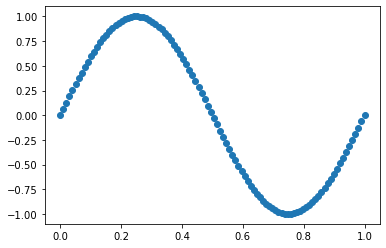

In [18]:
mu = 0.0
N = 100

# define f(x)=sin(2*pi*x)
def f(x):
    return np.sin(2*np.pi*x)

#plotting
x, t = generateDataset(N, f, 0.03)
plt.scatter(x, t)

In [19]:
def s(x): return x**2
def f(x): return math.sin(2 * math.pi * x)
vf = np.vectorize(f)        # Create a vectorized version of f

z = np.array([1,2,3,4])
print(z)

sz = s(z)                   # You can apply simple functions to an array
print(sz.shape)             # Same dimension as z (4)
print(sz)

fz = vf(z)                  # For more complex ones, you must use the vectorized version of f
print(fz.shape)
print(fz)

[1 2 3 4]
(4,)
[ 1  4  9 16]
(4,)
[-2.44929360e-16 -4.89858720e-16 -7.34788079e-16 -9.79717439e-16]


<a name="curvefitting"></a>
<h3>2.2 Polynomial Curve Fitting</h3>

We will attempt to learn the function y given a synthetic dataset $(x, t)$.

We assume that $y$ is a polynomial of degree $M$ - that is:

$y(x) = w_0 + w_1 x + w_2 x^2 + ... + w_M x^M$

Our objective is to estimate the vector $w = (w_0 \dots w_M)$ from the dataset $(x, t)$.

In [ ]:
import numpy as np
import scipy.linalg

t = np.array([1,2,3,4])                    # This is a vector of dim 4
t.shape                                    # (4,)
phi = np.array([[1,1],[2,4],[3,3],[2,4]])  # This is a 4x2 matrix
phi.shape                                  # (4, 2) 
prod = np.dot(phi.T, phi)                  # prod is a 2x2 matrix
prod.shape                                 # (2, 2)
i = np.linalg.inv(prod)                    # i is a 2x2 matrix
i.shape                                    # (2, 2)
m = np.dot(i, phi.T)                       # m is a 2x4 matrix
m.shape                                    # (2, 4)
w = np.dot(m, t)                           # w is a vector of dim 2
w.shape                                    # (2,)

We implement a method <b>optimizeLS(x, t, M)</b> which given the dataset $(x, t)$ returns the optimal polynomial of degree $M$ that approximates the dataset according to the least squares objective. 

In [20]:
def compute_matrix(x, M):
    arr = np.zeros([len(x), M+1], dtype=float)
    for i in range(len(x)):
        for m in range(M+1):
            arr[i, m] = x[i] ** m
    return arr

def optimizeLS(x, t, M):
    phi = compute_matrix(x, M)
    prod = np.dot(phi.T, phi)
    i = np.linalg.inv(prod)
    m = np.dot(i, phi.T)
    w = np.dot(m, t)
    return w

def polynomial(w, x_i, M):
    res = 0
    for i in range(M+1):
        res += w[i] * (x_i ** i)
    return res

We now plot the learned polynomial $w_M(x_i)$ and the real function $sin(2πx)$ for a dataset of size $N=10$ and $M=1,3,5,10$.


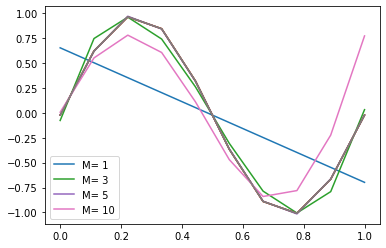

In [21]:
N = 10
M = [1, 3, 5, 10]
def f(x):return np.sin(2*np.pi*x)
x,t = generateDataset(N, f, 0.03)

for m in M:
    w = optimizeLS(x,t, m)
    y = polynomial(w, x, m)
    line1 = plt.plot(x, y,label=('M= '+str(m)))
    line2 = plt.plot(x,t)
    plt.legend()

plt.show()

let's try to plot each graph seperately to get more information

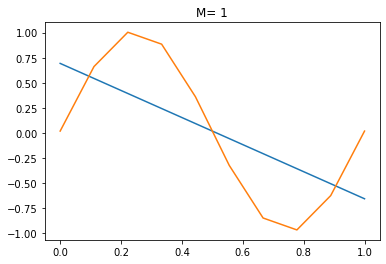

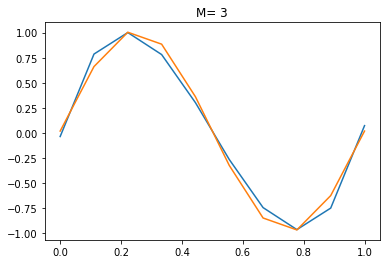

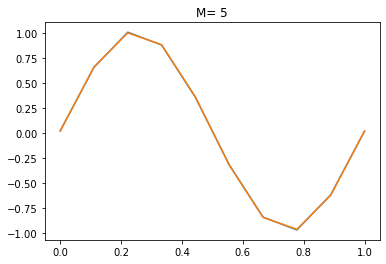

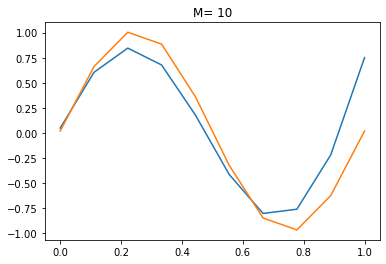

In [22]:
N = 10
M = [1, 3, 5, 10]
def f(x):return np.sin(2*np.pi*x)
x,t = generateDataset(N, f, 0.03)

for num in M:
    w = optimizeLS(x,t, num)
    y = polynomial(w, x, num)
    line1 = plt.plot(x, y)
    line2 = plt.plot(x,t)
    plt.title('M= '+str(num))
    plt.show()

We can tell that when M=5 we get overfitting!

<a name="regularization"></a>
<h3>2.3 Polynomial Curve Fitting with Regularization</h3>

We observe in the plot above that the solution to the least-squares optimization has a tendency to over-fit the dataset.

To avoid over-fitting, we will use <i>regularization</i>: the objective function we want to optimize will take into account the least-squares error as above, and in addition the complexity of the learned model $w$.

We write a function <b>optimizePLS(x, t, M, lambda)</b> which returns the optimal parameters $w_{PLS}$ given $M$ and $\lambda$.

In [23]:
def optimizePLS(x, t, M, lamb):
    phi = compute_matrix(x, M)
    tmp = np.dot(phi.T, phi)
    prod = tmp + (lamb * np.eye(int(M+1)))
    i = np.linalg.inv(prod)
    m = np.dot(i, phi.T)
    w = np.dot(m, t)
    return w

We want to optimize the value of λ. The way to optimize is to use a development set in addition to our training set.

To construct a development set, we extend our synthetic dataset construction function to return 3 samples:
* one for training, 
* one for development 
* and one for testing

In [24]:
# return xt,tt,vx,vt,xtst,vtst
def generateDataset3(N, f, sigma):
    x, t1 = generateDataset(N, f, sigma)
    x, t2 = generateDataset(N, f, sigma)
    x, t3 = generateDataset(N, f, sigma)
    list_tuple = {}
    for index in range(len(x)):
        list_tuple[x[index]] = [t1[index], t2[index], t3[index]]
        np.random.shuffle(list_tuple[x[index]])

    train = {}
    valid = {}
    test = {}
    for index in range(len(list_tuple)):
        train[x[index]] = list_tuple[x[index]][0]
        valid[x[index]] = list_tuple[x[index]][1]
        test[x[index]] = list_tuple[x[index]][2]
    
    return  np.fromiter(train.keys(),dtype=float), np.fromiter(train.values(),dtype=float)\
    ,np.fromiter(valid.keys(),dtype=float), np.fromiter(valid.values(),dtype=float)\
    , np.fromiter( test.keys(),dtype=float), np.fromiter(test.values(),dtype=float)


In [25]:
N = 10
M = 10
xt,tt,xv,tv,xtst,ttst = generateDataset3(N, f, 0.03)

print(make_bold ('xt:'),xt \
      ,make_bold ('tt:'),tt \
      ,make_bold ('xv:'),xv \
      ,make_bold ('tv:'),tv \
      ,make_bold ('xtst:'),xtst \
      ,make_bold ('ttst:'),ttst \
      ,sep='\n')


xt:
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
tt:
[ 0.0299109   0.67621694  0.94571246  0.89945474  0.37193104 -0.31210924
 -0.9051207  -1.02390305 -0.6818829   0.03342933]
xv:
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
tv:
[ 0.03342933  0.67269851  1.01471865  0.8959363   0.37544948 -0.30859081
 -0.83611451 -0.95137842 -0.60935828 -0.03909529]
xtst:
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
ttst:
[-0.03909529  0.60369232  1.01823709  0.82693011  0.30292485 -0.38111544
 -0.83259607 -0.95489685 -0.61287671  0.0299109 ]


Given a synthetic dataset, we optimize for the value of λ by varying the value of log(λ) from -40 to -20 on the development set. 

In [26]:
def normalized_error(x, t, N, M):
    # the indexes in the array are by the log result + 40
    # log(x) = -40 => errors_arr[0] = error_for_x
    errors = []
    for num in range(-40, -19):
        # get pls with lambda=2^num 
        w = optimizePLS(x, t, M, 2**num)
        # create the polynom
        pol_res = polynomial(w, x, M)
        #the error is L2
        error = float((math.sqrt(sum(pow((t - pol_res), 2)))) / N)
        errors.append(error)
    
    min_arg = np.argmin(errors)-40
    lamb = 2**float(min_arg)
    lambdas= [2**i for i in range(-40,-19)]
    plt.plot(lambdas,errors)

    plt.title("labmbda Vs.error")

    return lamb


In [27]:
def optimizePLS2(xt, tt, xv, tv, M):
    return normalized_error(xv, tv, len(tv), M)
    

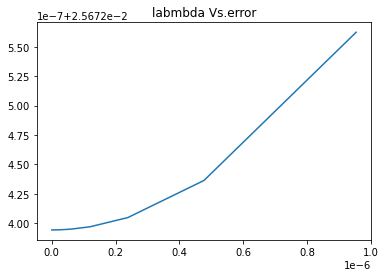

In [29]:
N = 10
M = 3
xt,tt,xv,tv,xtst,ttst = generateDataset3(N, f, 0.03)
lamb = optimizePLS2(xt, tt, xv, tv, M)

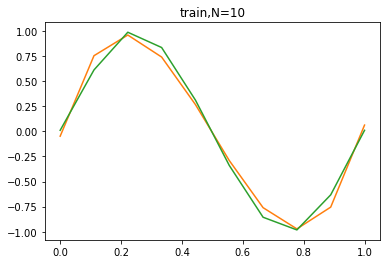

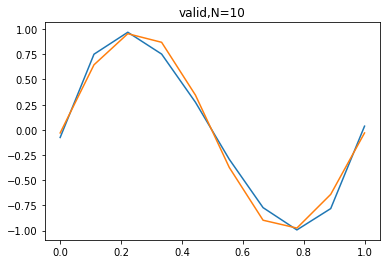

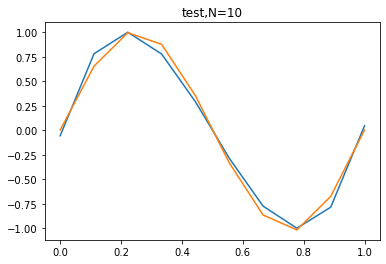

In [30]:
N = 10
M = 3
xt,tt,xv,tv,xtst,ttst = generateDataset3(N, f, 0.03)
lamb=optimizePLS2(xt, tt, xv, tv, M)

def plot_polynom(x,t,M,lamb,title,N):
    w= optimizePLS(x,t,M,lamb)
    y = polynomial(w,x, M)
    plt.title(f"{title},N={N}")
    line1 = plt.plot(x, y)
    line2 = plt.plot(x, t)
    plt.show()

    
plot_polynom(xt,tt,M,lamb,'train',N)
plot_polynom(xv,tv,M,lamb,'valid',N)
plot_polynom(xtst,ttst,M,lamb,'test',N)

Analyze the plots

<a name="prob-regr"></a>
<h3>2.4 Probabilistic Regression Framework</h3>

We now consider the same problem of regression (learning a function from a dataset) formulated in a probabilistic framework.

In [31]:
def bayesianEstimator(x_bold, t, M, alpha, sigma2):
    phi_x = compute_matrix(x_bold, M)
    phi_x = phi_x.T
    prod = np.dot(phi_x, phi_x.T)
    s_matrix_inv = alpha * np.eye(M + 1) + (1 / sigma2) * prod
    s_matrix = np.linalg.inv(s_matrix_inv)

    def var(x):
        x=np.array([x])
        tmp_matrix_x = compute_matrix(x, M)
        return sigma2 + np.linalg.multi_dot([tmp_matrix_x, s_matrix, tmp_matrix_x.T])

    def mean(x):
        x=np.array([x])
        tmp_matrix_x = compute_matrix(x, M)
        return (1/sigma2) * np.linalg.multi_dot([tmp_matrix_x, s_matrix, phi_x, t])

    return var,mean

We draw the plot of the original function $y = sin(2πx)$ over the range $[0 \dots 1]$, the mean of the predictive distribution $m(x)$ and the confidence interval $m(x) - \sqrt{var(x)}$ and $m(x) + \sqrt{var(x)}$ (that is, one standard deviation around each predicted point) for the values:
* $\alpha = 0.005$
* $\sigma^2 = 1/11.1$
* $M = 9$

over a synthetic dataset of size $N=10$ and $N=100$.

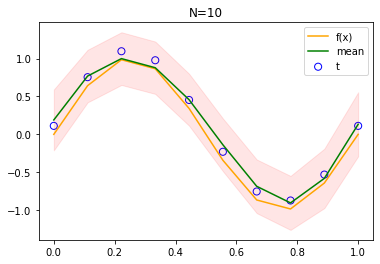

In [32]:
## Draw the plot
N = 10
M = 9
x, t = generateDataset(N, f, math.sqrt(1/11.1))
x=np.array(x)
var,mean = bayesianEstimator(x, t, M, 0.005, 1/11.1)
var=np.vectorize(var)
mean =np.vectorize(mean)

f1=mean(x)-np.sqrt(var(x))
f2=mean(x)+np.sqrt(var(x))

plt.title("N=10")
plt.plot(x, f(x),label='f(x)',color='orange')
plt.plot(x,mean(x),label='mean',color='g')
plt.scatter(x, t, facecolors='none',edgecolors='b',s=50,label='t')
plt.fill_between(x,f1,f2, color='r', alpha=.1)
plt.legend()

plt.show()

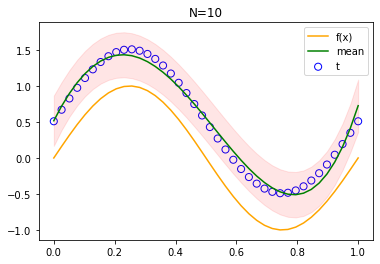

In [33]:
## Draw the plot
N = 40
M = 5
x, t = generateDataset(N, f, math.sqrt(1/11.1))
x=np.array(x)
var,mean = bayesianEstimator(x, t, M, 0.005, 1/11.1)
var=np.vectorize(var)
mean =np.vectorize(mean)

f1=mean(x)-np.sqrt(var(x))
f2=mean(x)+np.sqrt(var(x))

plt.title("N=10")
plt.plot(x, f(x),label='f(x)',color='orange')
plt.plot(x,mean(x),label='mean',color='g')
plt.scatter(x, t, facecolors='none',edgecolors='b',s=50,label='t')
plt.fill_between(x,f1,f2, color='r', alpha=.1)
plt.legend()

plt.show()

Interpret the height of the band around the most likely function in terms of the distribution of the xs in your synthetic dataset.
Can you think of ways to make this height very small in one segment of the function and large in another?

<hr/>
<hr/>
<a name="P3"></a>
<h2>Part 3: Neural Models for Classification</h2>

In this section, we adopt the PyTorch tutorial on 
<a href="https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html">Character RNN for classification</a>
to a different dataset.

<a name="readtut"></a>
<h3>3.1 Summarize the Tutorial</h3>

We summarize the <a href="https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html">PyTorch tutorial</a>:
* task
* method
* data encoding
* loss function 
* evaluation method

(Reading <a href="https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html">PyTorch Tensor Tutorial</a> helps)

<a name="newdata"></a>
<h3>3.2 Explore City Names Dataset</h3>

We use a dataset on city names in different countries to train a classifier.

The data from <a href="cities_val.zip">cities_val.zip</a> (validation) and <a href="cities_train.zip">cities_train.zip</a> (training)
is under "../data/cities/val" and "../data/cities/train".


In [34]:
import codecs
import math
import random
import string
import time
import numpy as np
from sklearn.metrics import accuracy_score

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

import unicodedata

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

Explore the train dataset by computing basic descriptive statistics:
number of categories, tokens per category, number of characters, distinct characters, average number of characters per token.

Explain why the unicodeToAscii is a good idea for this task.

unicodeToAscii is a good idea for this task because we wnt to remove accents, meaning normalize the input text. In that way we keep the text 'clean' from any different signs besides the letter (and spaces). unicodedata module defines character properties for all Unicode characters. normalize - Return the normal form form for a Unicode string. category - Returns the general category assigned to the character chr as string.

In [62]:
# Compute statistics over cities dataset
import glob
import os

def findFiles(path):
    return glob.glob(path)

all_data = ""
print(make_bold('number of characters in files:'))
for filename in findFiles('../data/cities/train/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    data = ' '.join(lines)
    print(make_underline(f'\t{category}:'),len(data))
    all_data += data
    category_lines[category] = lines

n_categories = len(set(all_categories))
print(make_bold('\nnumber of categories:'),n_categories)

toknes_num = 0
print(make_bold('\nnumber of tokens in catgory:'))

for c in category_lines:
    # number of rows in each file
    print(make_underline(f'\t{c}:'),len(category_lines[c]))
    toknes_num += len(category_lines[c])

len_char=len(all_data)
print(make_bold('\nnumber of characters in all files'),len_char)

dist_char = set(all_data)
print(make_bold('number of distinct characters: '),len(dist_char))

print(make_bold('average number of characters per token:'),(len_char/toknes_num))

number of characters in files:
	af: 35536
	cn: 31945
	de: 40376
	fi: 34036
	fr: 36447
	in: 36990
	ir: 36171
	pk: 37560
	za: 36109

number of categories: 9

number of tokens in catgory:
	af: 3000
	cn: 3000
	de: 3000
	fi: 3000
	fr: 3000
	in: 3000
	ir: 3000
	pk: 3000
	za: 3000

number of characters in all files 325170
number of distinct characters:  29
average number of characters per token: 12.043333333333333


In [ ]:
# Draw plots

<a name="citiesmodel"></a>
<h3>3.3 Train a Model and Evaluate It</h3>

Adopt the code of the PyTorch tutorial to run on this new dataset.

Report on performance in a similar manner.  Explain the main confusion cases observed in the confusion matrix.

In [36]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [37]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [40]:
input = letterToTensor('c')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
output

tensor([[-2.0963, -2.2514, -2.2199, -2.2247, -2.1402, -2.2161, -2.1983, -2.2996,
         -2.1442]], grad_fn=<LogSoftmaxBackward>)

In [45]:
input = lineToTensor('Chongjingdong')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.0823, -2.2746, -2.2351, -2.2985, -2.1534, -2.2245, -2.1600, -2.2356,
         -2.1314]], grad_fn=<LogSoftmaxBackward>)

In [46]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

categoryFromOutput(output)

('af', 0)

In [47]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = af / line = lalehkheyl
category = fr / line = la chauxdudombief
category = de / line = sauerthal
category = za / line = tafelehashe
category = af / line = khodzhashoab
category = af / line = adam ceray
category = pk / line = mehrbanwala
category = fr / line = mourioux
category = cn / line = yirengou
category = fi / line = ixtafiayuca


In [48]:
criterion = nn.NLLLoss()
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [49]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 12s) 2.1572 thatarwala / fi ✗ (pk)
10000 10% (0m 33s) 2.0458 retenue de vouglans / fr ✓
15000 15% (0m 54s) 2.1456 keshtak / za ✗ (ir)
20000 20% (1m 17s) 2.5488 chak one hundred sixteen / de ✗ (pk)
25000 25% (1m 37s) 1.9354 amrudiyehye su sefid / in ✗ (fi)
30000 30% (1m 58s) 2.3957 kungcuka / fi ✗ (za)
35000 35% (2m 18s) 0.8930 tungshihyang / cn ✓
40000 40% (2m 38s) 0.9935 houpuling / cn ✓
45000 45% (2m 59s) 1.8713 konari / pk ✗ (ir)
50000 50% (3m 19s) 1.3722 haidar khel / af ✓
55000 55% (3m 38s) 1.7739 laliwal / ir ✗ (af)
60000 60% (3m 57s) 1.5809 jinhaechon / cn ✗ (in)
65000 65% (4m 17s) 3.2608 parpodi / de ✗ (in)
70000 70% (4m 35s) 1.2783 goth bawal laghari / pk ✓
75000 75% (4m 54s) 2.1542 charvabolghay / af ✗ (ir)
80000 80% (5m 13s) 1.7195 igboayin dondo / in ✓
85000 85% (5m 33s) 0.7138 bussylettree / fr ✓
90000 90% (5m 54s) 0.6238 reza kan / za ✓
95000 95% (6m 15s) 1.6949 gozal darrehye pa'in / de ✗ (ir)
100000 100% (6m 34s) 2.3109 la esperanza de f. chavez / ir ✗ (za)


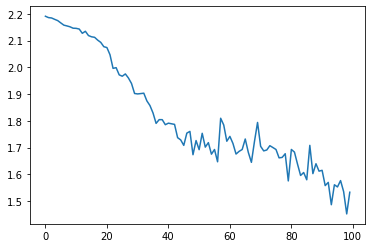

In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-51-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-51-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


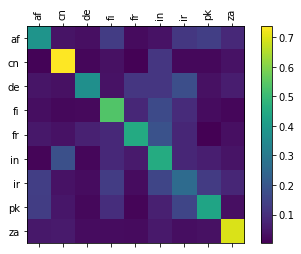

In [51]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [52]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('katiafi')
predict('le theuil')
predict('gilin')


> katiafi
(-0.83) fi
(-2.01) ir
(-2.02) pk

> le theuil
(-1.53) fr
(-1.74) in
(-1.84) ir

> gilin
(-0.64) in
(-2.09) cn
(-2.21) fi


In [53]:
confusion

tensor([[0.3821, 0.0420, 0.0329, 0.1335, 0.0229, 0.0393, 0.1225, 0.1380, 0.0868],
        [0.0103, 0.7382, 0.0145, 0.0351, 0.0077, 0.1198, 0.0171, 0.0188, 0.0385],
        [0.0443, 0.0358, 0.3695, 0.0377, 0.1178, 0.1178, 0.1791, 0.0368, 0.0613],
        [0.0309, 0.0194, 0.0221, 0.5380, 0.0857, 0.1678, 0.0936, 0.0265, 0.0159],
        [0.0487, 0.0389, 0.0690, 0.0867, 0.4522, 0.1894, 0.0805, 0.0027, 0.0319],
        [0.0136, 0.1833, 0.0155, 0.0863, 0.0563, 0.4559, 0.0824, 0.0640, 0.0427],
        [0.1396, 0.0394, 0.0274, 0.1344, 0.0283, 0.1567, 0.2611, 0.1301, 0.0830],
        [0.1356, 0.0482, 0.0173, 0.0992, 0.0118, 0.0664, 0.1556, 0.4331, 0.0328],
        [0.0493, 0.0565, 0.0269, 0.0278, 0.0251, 0.0529, 0.0305, 0.0358, 0.6953]])

<a name="bettercitiesmodel"></a>
<h3>3.4 Improve the RNN Model (Optional)</h3>

Explore methods to improve performance of the cities classifier.
Use a character RNN, dropout, better initialization.

Report on error reduction.